# Evaluation & Vizualization

## How metrics will be calculated:
### From top N - top 10

- Similarity -> avg Cosine Similarity
  - similarity_score.mean()

- Diversity -> variance of the Cosine Similarity Scores
  - np.var(similarity_score)
  - 1 - similarity_score

- Confidence -> standard deviation of Cosine Similarity Scores
  - similarity_score.std()
  - 1 / (1 + similarity_std) (inverted confidence)

### From threshold
- Coverage -> Number of unique recommendations / Total items in the dataset
  - round((len(recommendations['book_index'].unique()) / total_items)*100, 2)


## Ratings / Reviews / Genres -> in the GoodReads Dataset  
- Adding metadata to the recommended results for each algorithm to see which algo recommended books with more:
  - ratings
  - reviews
  - higher ratings
  - matching genres
- popularity and novelty will be calculated from this metadata


In [ ]:
import os
import pandas as pd

# Load and clean metadata
metadata = pd.read_csv("../datasets/book_details_clean.csv", encoding='ISO-8859-1')

# Clean numeric fields
metadata['no_of_ratings'] = (
    metadata['no_of_ratings']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)
metadata['no_of_reviews'] = (
    metadata['no_of_reviews']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)


base_directory_results = "results/results_for_description/results"
algos = ["bert", "bow", "fasttext", "glove", "lsa", "tf_idf", "e5"]

# Columns to preserve and enrich
keep_original = ['book_index', 'similarity_score']
enrich_cols = ['title', 'author', 'rating', 'no_of_ratings', 'no_of_reviews', 'genres']
ordered_cols = ['book_index', 'similarity_score'] + enrich_cols

# for every model
for algo in algos:
    algo_path = os.path.join(base_directory_results, algo)
    output_path = os.path.join(algo_path, "results_metadata")
    os.makedirs(output_path, exist_ok=True)

    for file in os.listdir(algo_path):
        if file.endswith(".csv"):

            run_path = os.path.join(algo_path, file)
            run_df = pd.read_csv(run_path)

            # Select only needed columns and ensure book_index is int
            clean_df = run_df[keep_original].copy()
            clean_df['book_index'] = clean_df['book_index'].astype(int)

            # Enrich rows using metadata
            def enrich_row(row):
                try:
                    index = int(row['book_index'])
                    if 0 <= index < len(metadata):
                        book = metadata.iloc[index]
                        for col in enrich_cols:
                            row[col] = book[col]
                    # else:
                        # print(f"Skipped out-of-range index {index} in file {file}")
                except Exception as e:
                    print(f"Error enriching row in file {file}: {e}")
                return row

            enriched_df = clean_df.apply(enrich_row, axis=1)

            # Enforce consistent column order
            enriched_df = enriched_df[ordered_cols]

            # Save output
            output_file = os.path.join(output_path, file)
            enriched_df.to_csv(output_file, index=False)
            # print(f"Saved: {output_file}")
    print(f"Saved: {algo_path}")
    


Saved: results/results_for_description/results\e5


## Calculate average - rating, no. rating, no. reviews, genre alignment 
- for Recommendations on GoodReads Dataset <br><br>

- If recommended items have more reviews and more ratings -> more popular recommendations  
- If recommended items have fewer reviews and ratings -> novel items <br><br>

- Set number for popularity / novelty threshold

In [ ]:
import os
import pandas as pd
import numpy as np
import re

# Load and clean full metadata
metadata = pd.read_csv("../datasets/book_details_clean.csv", encoding='ISO-8859-1')
metadata['no_of_ratings'] = (
    metadata['no_of_ratings']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)
metadata['no_of_reviews'] = (
    metadata['no_of_reviews']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)

# Global averages for weighted rating
C = metadata['rating'].mean()
m = metadata['no_of_ratings'].median()


# Directories and Config
base_path = "results/results_for_description/results"
algos = ["bert", "bow", "fasttext", "glove", "lsa", "tf_idf", "e5"]


# TOP N RESULTS
N = 10


# Storage for all results
all_algo_metrics = []

# Main loop
for algo in algos:
    algo_metrics = {
        "algorithm": algo,
        "avg_rating": [],
        "avg_no_of_ratings": [],
        "avg_no_of_reviews": [],
        "avg_weighted_rating": [],
        "avg_genre_alignment": []
    }

    metadata_dir = os.path.join(base_path, algo, "results_metadata")

    for filename in os.listdir(metadata_dir):
        if not filename.endswith(".csv"):
            continue

        # input_index_match = re.search(r'_(\d+)\.csv$', filename)
        input_index_match = re.search(r'_(\d+)(?:_[^_]*)?\.csv$', filename)

        if not input_index_match:
            continue

        input_index = int(input_index_match.group(1))
        input_genres_raw = metadata.loc[input_index, 'genres']
        input_genres = set(map(str.strip, str(input_genres_raw).split(',')))

        file_path = os.path.join(metadata_dir, filename)
        df = pd.read_csv(file_path)
        df = df.dropna(subset=['genres'])

        df = df.head(N)

        # Parse genres into sets
        df['genres'] = df['genres'].apply(lambda x: set(map(str.strip, str(x).split(','))))

        # Genre overlap
        genre_scores = df['genres'].apply(
            lambda g: len(input_genres & g) / len(input_genres) if len(input_genres) > 0 else 0
        )


        # Append run metrics
        algo_metrics["avg_rating"].append(df['rating'].mean())
        algo_metrics["avg_no_of_ratings"].append(df['no_of_ratings'].mean())
        algo_metrics["avg_no_of_reviews"].append(df['no_of_reviews'].mean())
        algo_metrics["avg_genre_alignment"].append(np.mean(genre_scores))

    # Compute average over all 10 runs
    all_algo_metrics.append({
        "algorithm": algo,
        "avg_rating": np.mean(algo_metrics["avg_rating"]),
        "avg_no_of_ratings": np.mean(algo_metrics["avg_no_of_ratings"]),
        "avg_no_of_reviews": np.mean(algo_metrics["avg_no_of_reviews"]),
        "genre_alignment (%)": round(np.mean(algo_metrics["avg_genre_alignment"]) * 100, 1)
    })

# Create final results DataFrame
results_df = pd.DataFrame(all_algo_metrics)

# Round values nicely
results_df = results_df.round({
    "avg_rating": 3,
    "avg_no_of_ratings": 0,
    "avg_no_of_reviews": 0
})

# Save cleaned version
output_path = os.path.join(base_path, "algo_recommendation_quality_metrics_cleaned.csv")
results_df.to_csv(output_path, index=False)
print(f"Cleaned metrics saved to {output_path}")
results_df.head(10)


### Novelty and Popularity of results

In [ ]:
import os
import pandas as pd
import numpy as np
import re

# Load and clean metadata
metadata = pd.read_csv("../datasets/book_details_clean.csv", encoding='ISO-8859-1')
metadata['no_of_ratings'] = metadata['no_of_ratings'].astype(str).str.replace(r'[^\d]', '', regex=True).astype(int)
metadata['no_of_reviews'] = metadata['no_of_reviews'].astype(str).str.replace(r'[^\d]', '', regex=True).astype(int)

# Thresholds for Popularity and Novelty
pop_rating_thresh = metadata['rating'].mean()
pop_no_ratings_thresh = np.percentile(metadata['no_of_ratings'], 75)
pop_no_reviews_thresh = np.percentile(metadata['no_of_reviews'], 75)

nov_rating_thresh = np.percentile(metadata['rating'], 25)
nov_no_ratings_thresh = np.percentile(metadata['no_of_ratings'], 25)
nov_no_reviews_thresh = np.percentile(metadata['no_of_reviews'], 25)

# Directories and Config
base_path = "results/results_for_description/results"
algos = ["bert", "bow", "fasttext", "glove", "lsa", "tf_idf", "e5"]
N = 10

all_algo_metrics = []

for algo in algos:
    pop_ratios = []
    nov_ratios = []

    metadata_dir = os.path.join(base_path, algo, "results_metadata")
    if not os.path.exists(metadata_dir):
        print(f"Missing metadata folder: {metadata_dir}")
        continue

    for filename in os.listdir(metadata_dir):
        if not filename.endswith(".csv"):
            continue

        file_path = os.path.join(metadata_dir, filename)
        df = pd.read_csv(file_path)
        df = df.dropna(subset=['rating', 'no_of_ratings', 'no_of_reviews'])
        df = df.head(N)

        # Identify popular items
        is_popular = (
            (df['rating'] > pop_rating_thresh) &
            (df['no_of_ratings'] > pop_no_ratings_thresh) &
            (df['no_of_reviews'] > pop_no_reviews_thresh)
        )

        # Identify novel items
        is_novel = (
            (df['rating'] < nov_rating_thresh) &
            (df['no_of_ratings'] < nov_no_ratings_thresh) &
            (df['no_of_reviews'] < nov_no_reviews_thresh)
        )

        # Compute ratios
        pop_ratio = is_popular.sum() / len(df)
        nov_ratio = is_novel.sum() / len(df)

        pop_ratios.append(pop_ratio)
        nov_ratios.append(nov_ratio)

    all_algo_metrics.append({
        "Algorithm": algo,
        "popularity_ratio (%)": round(np.mean(pop_ratios) * 100, 2),
        "novelty_ratio (%)": round(np.mean(nov_ratios) * 100, 2),
    })

    # print(f"{algo}:\t{pop_ratios}")
    # print(nov_ratios)

# Final Results
results_df = pd.DataFrame(all_algo_metrics)
output_path = os.path.join(base_path, "algo_popularity_novelty_metrics.csv")
results_df.to_csv(output_path, index=False)
print(f"Popularity/Novelty metrics saved to {output_path}")
results_df.head(10)

Popularity/Novelty metrics saved to results/results_for_description/results\algo_popularity_novelty_metrics.csv


,Algorithm,popularity_ratio (%),novelty_ratio (%)
0,bert,18.00,3.0
1,bow,25.00,5.0
2,fasttext,9.00,2.0
3,glove,13.00,3.0
4,lsa,16.00,2.0
5,tf_idf,9.56,2.0
6,e5,10.33,5.0


### Try Radar-chart vizualization

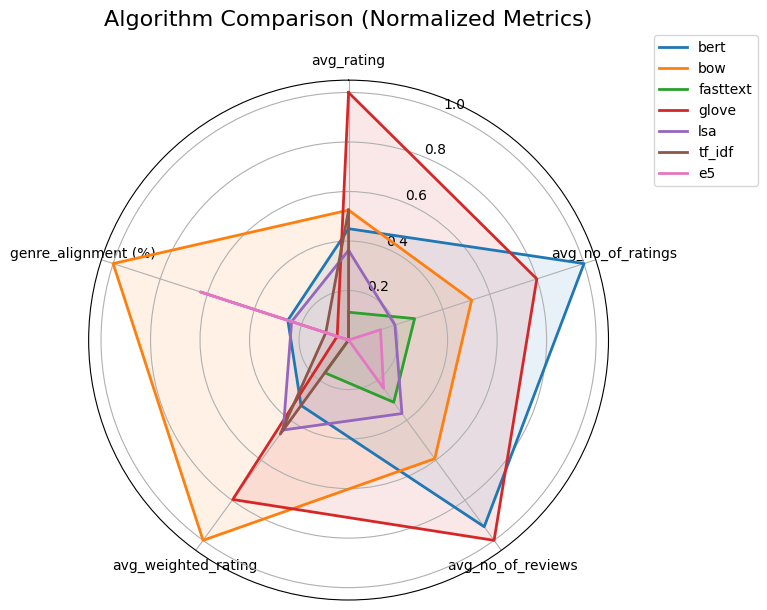

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('results/results_for_description/results/algo_recommendation_quality_metrics_cleaned.csv')

# Normalize values for radar chart
metrics = df.columns[1:]
normalized_df = df.copy()
for metric in metrics:
    min_val = df[metric].min()
    max_val = df[metric].max()
    normalized_df[metric] = (df[metric] - min_val) / (max_val - min_val)

# Radar chart setup
labels = list(metrics)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Loop

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each algorithm
for i, row in normalized_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # Loop
    ax.plot(angles, values, label=row['algorithm'], linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Configure plot aesthetics
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Algorithm Comparison (Normalized Metrics)", size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


### Try Heatmap visualization

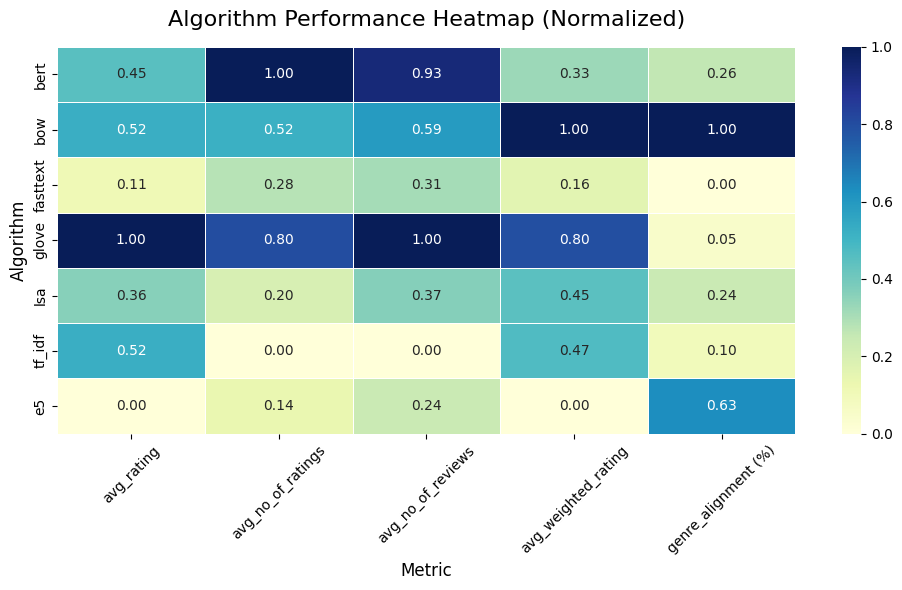

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned metrics from CSV
df = pd.read_csv('results/results_for_description/results/algo_recommendation_quality_metrics_cleaned.csv')
df.set_index("algorithm", inplace=True)

# Normalize values (0–1 scale) across each column
normalized_df = (df - df.min()) / (df.max() - df.min())

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_df, annot=True, cmap="YlGnBu", linewidths=0.5, fmt=".2f", annot_kws={"size": 10})

# Style and labels
plt.title("Algorithm Performance Heatmap (Normalized)", fontsize=16, pad=15)
plt.ylabel("Algorithm", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# Calculating METRICS - Sim/Div/Conf/Cov/Time/Memory/GPU/CPU

## Metrics - show result averages - for 1 model - 10 runs

In [ ]:
import os
import pandas as pd
import numpy as np

# Base directory where all algorithm folders and CSVs are located
base_directory = 'results/results_for_description/results/e5'

# Total number of items in the dataset for coverage calculation
total_items = 13263.0
N = 10

def calculate_metrics_for_csv(file_path):
    df = pd.read_csv(file_path)
    
    recommendations_cov = df
    recommendations_topN = df.head(N)
    
    # Calculate average similarity score for the CSV
    avg_similarity = recommendations_topN['similarity_score'].mean()

    # Coverage: Number of unique recommendations / Total items in the dataset
    coverage = round((len(recommendations_cov['book_index'].unique()) / total_items)*100,2)

    # Confidence: Proportion of non-zero similarity scores
    similarity_std = recommendations_topN['similarity_score'].std()
    confidence = 1 / (1 + similarity_std)  # Inverted confidence

    # Diversity: Variance of similarity scores
    diversity_variance = np.var(recommendations_topN['similarity_score'])
    diversity_dissimilarity = (1 - recommendations_topN['similarity_score']).mean()
    
    # Return the metrics for this CSV file
    return {
        'file': os.path.basename(file_path),
        'avg_similarity': avg_similarity,
        'coverage': coverage,
        'confidence': confidence,
        'diversity_variance': diversity_variance,
        'diversity_dissimilarity': diversity_dissimilarity
    }

# Main function to process all CSVs in the specified algorithm folder
def process_algorithm_folder(base_directory):
    all_results = []

    # Iterate through each CSV file in the folder
    for file in os.listdir(base_directory):
        if file.endswith('.csv'):
            file_path = os.path.join(base_directory, file)
            
            metrics = calculate_metrics_for_csv(file_path)
            all_results.append(metrics)
    
    metrics_df = pd.DataFrame(all_results)

    return metrics_df

# Process the CSV files and calculate metrics
metrics_df = process_algorithm_folder(base_directory)

metrics_df.head(10)


,file,avg_similarity,coverage,confidence,diversity_variance,diversity_dissimilarity
0,e5_results_70_None.csv,0.841200,10.84,0.988521,0.000121,0.158800
1,e5_results_71_None.csv,0.856400,7.25,0.991280,0.000070,0.143600
2,e5_results_72_None.csv,0.798200,0.37,0.980543,0.000354,0.201800
3,e5_results_73_None.csv,0.866800,7.60,0.992025,0.000058,0.133200
4,e5_results_74_None.csv,0.833200,8.20,0.989499,0.000101,0.166800
5,e5_results_75_None.csv,0.826200,53.47,0.998252,0.000003,0.173800
6,e5_results_76_None.csv,0.832000,49.14,0.994948,0.000023,0.168000
7,e5_results_77_None.csv,0.857100,20.06,0.992071,0.000057,0.142900
8,e5_results_78_None.csv,0.831000,25.97,0.989683,0.000098,0.169000
9,e5_results_79_None.csv,0.864167,0.05,0.966216,0.001019,0.135833


## Metrics - calculate result averages - for all 7 models

In [ ]:
import os
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.7f}'.format

def calculate_metrics_for_csv(file_path, total_items):
    if "summary" in file_path:
        return

    N = 10

    df = pd.read_csv(file_path)

    recommendations_cov = df
    recommendations_topN = df.head(N)
    
    # Coverage: Number of unique recommendations / Total items in the dataset
    coverage = round((len(recommendations_cov['book_index'].unique()) / total_items)*100, 2)

    # Calculate average similarity score for the CSV
    avg_similarity = recommendations_topN['similarity_score'].mean()

    # Confidence: Standard deviation of similarity scores for this run
    similarity_std = recommendations_topN['similarity_score'].std()
    confidence = 1 / (1 + similarity_std)  # Inverted confidence

    # Diversity: Variance of similarity scores
    diversity_variance = np.var(recommendations_topN['similarity_score'])
    diversity_dissimilarity = (1 - recommendations_topN['similarity_score']).mean()
    
    # Return the metrics for this CSV file
    return {
        'file': os.path.basename(file_path),
        'avg_similarity': avg_similarity,
        'coverage': coverage,
        'confidence': confidence,
        'diversity_variance': diversity_variance,
        'diversity_dissimilarity': diversity_dissimilarity
    }

def process_algorithm_folder(base_directory, total_items):
    all_results = []

    # Iterate through each CSV file in the folder
    for file in os.listdir(base_directory):
        if file.endswith('.csv'):
            file_path = os.path.join(base_directory, file)
            
            # Calculate metrics for the current CSV file
            metrics = calculate_metrics_for_csv(file_path, total_items)
            if metrics: 
                all_results.append(metrics)
    
    metrics_df = pd.DataFrame(all_results)

    def truncate(number, decimals=0):
        factor = 10.0 ** decimals
        return np.floor(number * factor) / factor

    np.set_printoptions(suppress=True)


    avg_sim = truncate(metrics_df['avg_similarity'].mean(),3)
    avg_cov = truncate(metrics_df['coverage'].mean(),2)
    avg_conf = truncate(metrics_df['confidence'].mean(),5)
    avg_div_variance = truncate(metrics_df['diversity_variance'].mean(), 10)
    avg_div_dissimilarity = truncate(metrics_df['diversity_dissimilarity'].mean(), 4)


    # Calculate the average metrics for the algorithm (average across all runs)
    avg_metrics = {
        'Algorithm': os.path.basename(base_directory),
        'avg_similarity': avg_sim,
        'coverage': avg_cov,
        'confidence': avg_conf,
        'diversity_variance': avg_div_variance,
        'diversity_dissimilarity': avg_div_dissimilarity
    }

    # Save the metrics of individual runs for the algorithm
    metrics_df.to_csv(f'{base_directory}_metrics_per_run.csv', index=False)

    return avg_metrics, metrics_df

def process_all_algorithms(base_directory_root, total_items):
    all_algorithms_metrics = []
    for algo_folder in os.listdir(base_directory_root):
        algo_folder_path = os.path.join(base_directory_root, algo_folder)
        
        if os.path.isdir(algo_folder_path):
            # Process each algorithm folder and get its average metrics
            avg_metrics, run_metrics_df = process_algorithm_folder(algo_folder_path, total_items)
            
            # avg_metrics['diversity'] = avg_metrics['diversity'].round(7) 
            all_algorithms_metrics.append(avg_metrics)
    
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/average_metrics.csv', index=False, float_format='%.10f')
    
    return final_metrics_df

# Define the base directory containing the algorithm folders (e.g., 'bert', 'bow', 'fasttext', etc.)
base_directory_root_description = 'results/results_for_description/results'
base_directory_root_paragraph = 'results/results_for_paragraph/results'


# Total number of items in the dataset for coverage calculation
total_items_description = 13263
total_items_paragraph = 45461

# Process all algorithms and save the final summary
average_metrics_df_decsription = process_all_algorithms(base_directory_root_description, total_items_description)
average_metrics_df_paragraph = process_all_algorithms(base_directory_root_paragraph, total_items_paragraph)



In [13]:
import pandas as pd

df = pd.read_csv("results/results_for_description/results/average_metrics.csv")
df.head(10)

,Algorithm,avg_similarity,coverage,confidence,diversity_variance,diversity_dissimilarity
0,bert,0.5130000,9.2900000,0.9603900,0.0022252,0.4866000
1,bow,0.2460000,1.2900000,0.9775500,0.0005925,0.7530000
2,e5,0.8400000,18.2900000,0.9883000,0.0001905,0.1593000
3,fasttext,0.9700000,15.3100000,0.9976500,0.0000060,0.0299000
4,glove,0.9950000,21.5200000,0.9994600,0.0000003,0.0045000
5,lsa,0.4080000,1.2000000,0.9647300,0.0014899,0.5917000
6,tf_idf,0.2310000,0.3400000,0.9664800,0.0014117,0.7684000


In [14]:
import pandas as pd

df = pd.read_csv("results/results_for_paragraph/results/average_metrics.csv")
df.head(10)

,Algorithm,avg_similarity,coverage,confidence,diversity_variance,diversity_dissimilarity
0,bert,0.5360000,0.1900000,0.9765400,0.0006018,0.4630000
1,bow,0.3780000,0.2200000,0.9119000,0.0178140,0.6210000
2,e5,0.8570000,0.5500000,0.9935200,0.0000487,0.1429000
3,fasttext,0.9730000,0.5300000,0.9979100,0.0000068,0.0264000
4,glove,0.9860000,0.2500000,0.9987700,0.0000020,0.0134000
5,lsa,0.6110000,0.1200000,0.9623100,0.0014689,0.3886000
6,tf_idf,0.3630000,0.0500000,0.9594500,0.0017445,0.6368000


## Average elapsed time for models

In [41]:
import os
import pandas as pd

def calculate_avg_metrics_for_algorithm(file_path):
    if "average_times" in file_path:
        return

    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Calculate the average elapsed time and average iterations per second
    avg_elapsed_time = df['elapsed_time'].mean()
    # avg_ips = df['iterations_per_second'].mean()

    # Return the metrics for this algorithm
    return {
        'Algorithm': os.path.basename(file_path).replace('_multi_performance_summary.csv', ''),
        'avg_elapsed_time': round(avg_elapsed_time,3),
        # 'avg_ips': round(avg_ips,3)
    }

def process_all_algorithm_times(base_directory_root):
    all_algorithms_metrics = []
    
    # Iterate through each time result CSV file in the folder?
    for file in os.listdir(base_directory_root):
        if file.endswith('.csv'):
            file_path = os.path.join(base_directory_root, file)
            
            # Calculate metrics for the current algorithm
            avg_metrics = calculate_avg_metrics_for_algorithm(file_path)
            if avg_metrics is not None:
                all_algorithms_metrics.append(avg_metrics)
    
    # Create a DataFrame from the average metrics of all algorithms
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/average_times.csv', index=False)
    
    return final_metrics_df



# Define the base directory containing the algorithm time result files
base_directory_root_description = 'results/results_for_description/times_descriptions'
base_directory_root_paragraph = 'results/results_for_paragraph/times_paragraphs'

# Process all algorithms and save the final summary
average_times_decription = process_all_algorithm_times(base_directory_root_description)
average_times_paragraph = process_all_algorithm_times(base_directory_root_paragraph)

# Print the final summary DataFrame for all algorithms
average_times_decription.head(10)


,Algorithm,avg_elapsed_time
0,bert,21.2170000
1,bow,3.7220000
2,e5,100.9550000
3,fasttext,13.3730000
4,glove,4.6460000
5,lsa,3.5010000
6,tf_idf,3.9730000


## Average used memory for models

In [ ]:
import os
import pandas as pd

def calculate_avg_memory_usage_for_algorithm(file_path):
    df = pd.read_csv(file_path)
    
    # Calculate the average memory usage for the algorithm (across all timestamps)
    avg_memory_usage = df['memory_usage'].mean()

    # Return the metrics for this algorithm
    return {
        'Algorithm': os.path.basename(file_path),
        'avg_memory_usage': avg_memory_usage
    }

def process_all_algorithm_memory_usage(base_directory_root):
    all_algorithms_metrics = []
    
    # Iterate through each memory usage result CSV file in the folder
    for algo_folder in os.listdir(base_directory_root):
        algo_folder_path = os.path.join(base_directory_root, algo_folder)
        
        if os.path.isdir(algo_folder_path):
            total_memory_usage = 0
            num_runs = 0
            
            # Process each CSV file in the algorithm folder (representing individual runs)
            for file in os.listdir(algo_folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(algo_folder_path, file)
                    
                    # Calculate metrics for the current algorithm run
                    avg_metrics = calculate_avg_memory_usage_for_algorithm(file_path)
                    total_memory_usage += avg_metrics['avg_memory_usage']
                    num_runs += 1
            
            # Calculate the average memory usage across all runs for this algorithm
            avg_memory_usage = total_memory_usage / num_runs if num_runs > 0 else 0
            
            # Save the average memory usage for the algorithm
            all_algorithms_metrics.append({
                'Algorithm': algo_folder,
                'avg_memory_usage': round(avg_memory_usage, 2)
            })
    
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/memory_usage_summary.csv', index=False)
    
    return final_metrics_df


# Define the base directory containing the algorithm time result files
base_directory_root_description = 'results/results_for_description/memory_tracking'
base_directory_root_paragraph = 'results/results_for_paragraph/memory_tracking'

# Process all algorithms and save the final summary
memory_df_description = process_all_algorithm_memory_usage(base_directory_root_description)
memory_df_paragraph = process_all_algorithm_memory_usage(base_directory_root_paragraph)

memory_df_description.head(10)


,Algorithm,avg_memory_usage
0,bert,1141.3800000
1,bow,202.8900000
2,e5,1200.3500000
3,fasttext,1193.4300000
4,glove,344.3300000
5,lsa,424.8500000
6,tf_idf,193.6400000


## Average used GPU memory for - Bert, E5

In [ ]:
import os
import pandas as pd

def calculate_avg_gpu_memory_usage_for_algorithm(file_path):
    df = pd.read_csv(file_path)
    
    # Calculate the average memory usage for the algorithm (across all timestamps)
    avg_gpu_memory_usage = df['gpu_memory'].mean()

    # Return the metrics for this algorithm
    return {
        'Algorithm': os.path.basename(file_path),
        'avg_gpu_memory_usage': avg_gpu_memory_usage
    }

def process_all_algorithm_memory_usage(base_directory_root):
    all_algorithms_metrics = []
    
    # Iterate through each memory usage result CSV file in the folder
    for algo_folder in os.listdir(base_directory_root):
        algo_folder_path = os.path.join(base_directory_root, algo_folder)
        
        if os.path.isdir(algo_folder_path):
            total_gpu_memory_usage = 0
            num_runs = 0
            
            # Process each CSV file in the algorithm folder (representing individual runs)
            for file in os.listdir(algo_folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(algo_folder_path, file)
                    
                    # Calculate metrics for the current algorithm run
                    avg_metrics = calculate_avg_gpu_memory_usage_for_algorithm(file_path)
                    total_gpu_memory_usage += avg_metrics['avg_gpu_memory_usage']
                    num_runs += 1
            
            # Calculate the average memory usage across all runs for this algorithm
            avg_gpu_memory_usage = total_gpu_memory_usage / num_runs if num_runs > 0 else 0
            
            # Save the average memory usage for the algorithm
            all_algorithms_metrics.append({
                'Algorithm': algo_folder,
                'avg_gpu_memory_usage': round(avg_gpu_memory_usage, 2)
            })
    
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/gpu_memory_usage_summary.csv', index=False)
    
    return final_metrics_df


# Define the base directory containing the algorithm time result files
base_directory_root_description = 'results/results_for_description/gpu_tracking'
base_directory_root_paragraph = 'results/results_for_paragraph/gpu_tracking'

# Process all algorithms and save the final summary
gpu_df_description = process_all_algorithm_memory_usage(base_directory_root_description)
gpu_df_paragraph = process_all_algorithm_memory_usage(base_directory_root_paragraph)

gpu_df_description.head(10)


,Algorithm,avg_gpu_memory_usage
0,bert,563.7800000
1,bow,1.0000000
2,e5,1732.0100000
3,fasttext,1.0000000
4,glove,1.0000000
5,lsa,1.0000000
6,tf_idf,1.0000000


## Average elapsed CPU time for models

In [ ]:
import os
import pandas as pd


def cpu_time_for_algorithm(file_path):
    df = pd.read_csv(file_path)
    
    # Calculate the average total CPU time for the algorithm (across all runs)
    avg_cpu_time = df['total_cpu_time'].mean()

    # Return the metrics for this algorithm 
    return {
        'Algorithm': os.path.basename(file_path),
        'avg_cpu_time': avg_cpu_time
    }

def process_all_algorithm_cpu_time(base_directory_root):
    all_algorithms_metrics = []
    
    # Iterate through each CPU time result CSV file in the folder
    for algo_folder in os.listdir(base_directory_root):
        algo_folder_path = os.path.join(base_directory_root, algo_folder)
        
        if os.path.isdir(algo_folder_path):
            total_cpu_time = 0
            num_runs = 0
            
            # Process each CSV file in the algorithm folder (representing individual runs)
            for file in os.listdir(algo_folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(algo_folder_path, file)
                    
                    # Calculate metrics for the current algorithm run
                    avg_metrics = cpu_time_for_algorithm(file_path)
                    total_cpu_time += avg_metrics['avg_cpu_time']
                    num_runs += 1
            
            # Calculate the average CPU time across all runs for this algorithm
            avg_cpu_time = total_cpu_time / num_runs if num_runs > 0 else 0
            avg_cpu_time = avg_cpu_time.round(3)

            # Save the average CPU time for the algorithm
            all_algorithms_metrics.append({
                'Algorithm': algo_folder,
                'avg_cpu_time': avg_cpu_time
            })
    
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/cpu_time_summary.csv', index=False)
    
    return final_metrics_df

# Define the base directory containing the algorithm CPU time result files
base_directory_root_description = 'results/results_for_description/cpu_tracking'
base_directory_root_paragraph = 'results/results_for_paragraph/cpu_tracking'

# Process all algorithms and save the final summary
cpu_avg_description = process_all_algorithm_cpu_time(base_directory_root_description)
cpu_avg_paragraph = process_all_algorithm_cpu_time(base_directory_root_paragraph)

cpu_avg_description.head(10)


,Algorithm,avg_cpu_time
0,bert,27.7570000
1,bow,0.2750000
2,e5,106.7770000
3,fasttext,11.8210000
4,glove,3.2100000
5,lsa,2.0410000
6,tf_idf,1.7290000


## Merged results for metrics

In [24]:
import pandas as pd


# DESCRIPTIONS
description_metrics = pd.read_csv("results/results_for_description/results/average_metrics.csv")
description_nov_pop = pd.read_csv("results/results_for_description/results/algo_popularity_novelty_metrics.csv")

# Merge all DataFrames on the "Algorithm" column
description_final = pd.merge(description_metrics, description_nov_pop, on='Algorithm', how='outer')

# Save the final combined DataFrame to a CSV file
description_final.to_csv('results/results_for_description/results/final_combined_algorithm_description.csv', index=False)


# PARAGRAPHS
paragraph_metrics = pd.read_csv("results/results_for_paragraph/results/average_metrics.csv")
paragraph_metrics.to_csv('results/results_for_paragraph/results/final_combined_algorithm_paragraph.csv', index=False)

# PRINT
description_final.head(10)
# paragraph_metrics.head(10)

,Algorithm,avg_similarity,coverage,confidence,diversity_variance,diversity_dissimilarity,popularity_ratio (%),novelty_ratio (%)
0,bert,0.5130000,9.2900000,0.9603900,0.0022252,0.4866000,18.0000000,3.0000000
1,bow,0.2460000,1.2900000,0.9775500,0.0005925,0.7530000,25.0000000,5.0000000
2,e5,0.8400000,18.2900000,0.9883000,0.0001905,0.1593000,10.3300000,5.0000000
3,fasttext,0.9700000,15.3100000,0.9976500,0.0000060,0.0299000,9.0000000,2.0000000
4,glove,0.9950000,21.5200000,0.9994600,0.0000003,0.0045000,13.0000000,3.0000000
5,lsa,0.4080000,1.2000000,0.9647300,0.0014899,0.5917000,16.0000000,2.0000000
6,tf_idf,0.2310000,0.3400000,0.9664800,0.0014117,0.7684000,9.5600000,2.0000000


## Merged results for time/memory/cpu/gpu_memory

In [ ]:
import pandas as pd

# DESCRIPTIONS
description_cpu = pd.read_csv("results/results_for_description/cpu_tracking/cpu_time_summary.csv")
description_gpu = pd.read_csv("results/results_for_description/gpu_tracking/gpu_memory_usage_summary.csv")
description_memory = pd.read_csv("results/results_for_description/memory_tracking/memory_usage_summary.csv")
description_times = pd.read_csv("results/results_for_description/times_descriptions/average_times.csv")

description_resource_final = pd.merge(description_cpu, description_gpu, on='Algorithm', how='outer')
description_resource_final = pd.merge(description_resource_final, description_memory, on='Algorithm', how='outer')
description_resource_final = pd.merge(description_resource_final, description_times, on='Algorithm', how='outer')
description_resource_final.to_csv('results/results_for_description/results/final_combined_algorithm_resource_description.csv', index=False)


# PARAGRAPHS
paragraph_cpu = pd.read_csv("results/results_for_paragraph/cpu_tracking/cpu_time_summary.csv")
paragraph_gpu = pd.read_csv("results/results_for_paragraph/gpu_tracking/gpu_memory_usage_summary.csv")
paragraph_memory = pd.read_csv("results/results_for_paragraph/memory_tracking/memory_usage_summary.csv")
paragraph_times = pd.read_csv("results/results_for_paragraph/times_paragraphs/average_times.csv")

paragraph_resource_final = pd.merge(paragraph_cpu, paragraph_gpu, on='Algorithm', how='outer')
paragraph_resource_final = pd.merge(paragraph_resource_final, paragraph_memory, on='Algorithm', how='outer')
paragraph_resource_final = pd.merge(paragraph_resource_final, paragraph_times, on='Algorithm', how='outer')
paragraph_resource_final.to_csv('results/results_for_paragraph/results/final_combined_algorithm_resource_paragraph.csv', index=False)

paragraph_resource_final.head(10)
# description_resource_final.head(10)

,Algorithm,avg_cpu_time,avg_gpu_memory_usage,avg_memory_usage,avg_elapsed_time
0,bert,103.3990000,670.8900000,1227.4400000,74.4560000
1,bow,0.8090000,1.0000000,378.4500000,15.2560000
2,e5,482.1570000,1824.2000000,1313.2800000,453.6940000
3,fasttext,44.9640000,1.0000000,2002.8000000,49.9590000
4,glove,10.3140000,1.0000000,420.7800000,14.8880000
5,lsa,8.1790000,1.0000000,744.6400000,13.2480000
6,tf_idf,7.2300000,1.0000000,293.4900000,15.2060000


# Charts - Visualization

## Radar chart - book descriptions metrics results

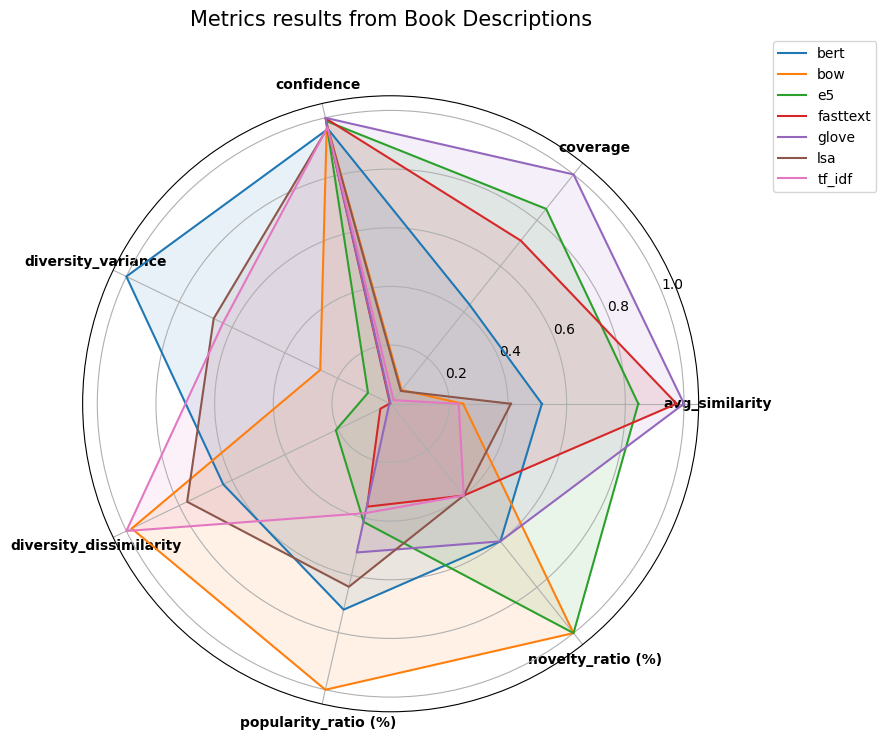

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('results/results_for_description/results/final_combined_algorithm_description.csv')


# Normalize data for radar chart (0-1 scale)
selected_metrics = ['avg_similarity', 'coverage', 'confidence', 'diversity_variance', 'diversity_dissimilarity', 'popularity_ratio (%)', 'novelty_ratio (%)']

df = df[['Algorithm'] + selected_metrics]
metrics = selected_metrics
df_norm = df.copy()
for metric in metrics:
    max_val = df[metric].max()
    df_norm[metric] = df[metric] / max_val  # normalize to [0, 1]

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each algorithm
for i, row in df_norm.iterrows():
    values = row[1:].tolist()
    values += values[:1]  # repeat the first value to close the circle
    ax.plot(angles, values, label=row['Algorithm'])
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontweight='bold')
# ax.set_yticklabels([]) 
ax.set_title("Metrics results from Book Descriptions", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


## Radar chart - book paragraphs metrics results

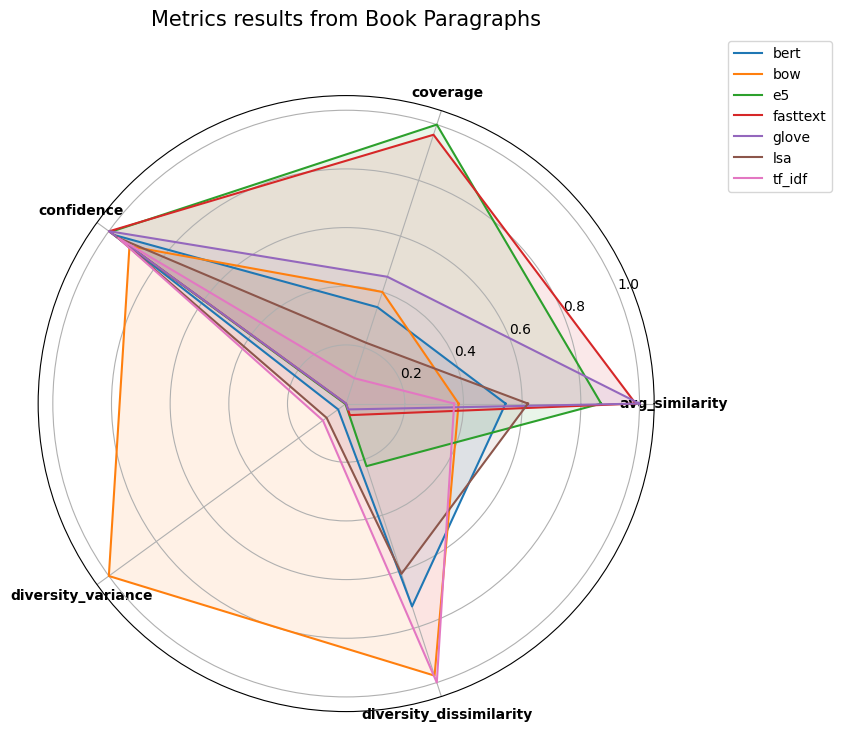

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('results/results_for_paragraph/results/final_combined_algorithm_paragraph.csv')


# Normalize data for radar chart (0-1 scale)
selected_metrics = ['avg_similarity', 'coverage', 'confidence', 'diversity_variance', 'diversity_dissimilarity']
df = df[['Algorithm'] + selected_metrics]
metrics = selected_metrics
df_norm = df.copy()
for metric in metrics:
    max_val = df[metric].max()
    df_norm[metric] = df[metric] / max_val  # normalize to [0, 1]

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each algorithm
for i, row in df_norm.iterrows():
    values = row[1:].tolist()
    values += values[:1]  # repeat the first value to close the circle
    ax.plot(angles, values, label=row['Algorithm'])
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontweight='bold')
# ax.set_yticklabels([])  
ax.set_title("Metrics results from Book Paragraphs", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()
